In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.datasets.wilds_dataset import WILDSSubset

from models import DeepDANN
from mixup import mixup_criterion
import options
import random

from main import get_wilds_dataset, get_split, get_eval_loader, build_model
from main import NUM_CLASSES, DEFAULT_TRANSFORM, NUM_DOMAINS, METADATA_KEYS

import sklearn
from sklearn.manifold import TSNE 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

cam_mix = 'weights/camelyon-mixup.pth'
cam_nomix = 'weights/camelyon-nomixup_final_2021-05-26T17:56:21.262615.pth'
iwild_mix = 'weights/iwildcam-mixup-3epoch_final_2021-05-25T18:25:23.230189.pth'
iwild_nomix = 'weights/from-ep2-iwildcam-mixup-3epoch_final_2021-05-26T05:52:54.712932.pth'

In [2]:
def scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, img_name):
    fig, ax = plt.subplots()
    train_fig = sns.scatterplot(x=d_train[:,0], y=d_train[:,1],hue=Y_train,palette=sns.color_palette("Blues",np.unique(Y_train).shape[0]),alpha=0.7,ax=ax)
    val_fig = sns.scatterplot(x=d_val[:,0], y=d_val[:,1],hue=Y_val,palette=sns.color_palette("Greens",np.unique(Y_val).shape[0]),alpha=0.7,ax=ax)
    test_fig = sns.scatterplot(x=d_test[:,0], y=d_test[:,1],hue=Y_test,palette=sns.color_palette("Oranges",np.unique(Y_test).shape[0]),alpha=0.7,ax=ax)


    train_fig.tick_params(bottom=False, left=False)
    train_fig.set(xticklabels=[])
    train_fig.set(yticklabels=[])
    train_norm = plt.Normalize(Y_train.min(), Y_train.max())
    train_sm = plt.cm.ScalarMappable(cmap="Blues", norm=train_norm)
    train_sm.set_array([])
    train_cax = fig.add_axes([0.25, 0.1, 0.15, 0.01])
    ax.figure.colorbar(train_sm,label="Train", ticks=[], cax=train_cax, orientation = 'horizontal')


    val_fig.tick_params(bottom=False, left=False)
    val_fig.set(xticklabels=[])
    val_fig.set(yticklabels=[])
    val_norm = plt.Normalize(Y_val.min(), Y_val.max())
    val_sm = plt.cm.ScalarMappable(cmap="Greens", norm=val_norm)
    val_sm.set_array([])
    val_cax = fig.add_axes([0.45, 0.1, 0.15, 0.01])
    ax.figure.colorbar(val_sm, label="Val", ticks=[], cax=val_cax, orientation='horizontal')

    test_fig.tick_params(bottom=False, left=False)
    test_fig.set(xticklabels=[])
    test_fig.set(yticklabels=[])
    test_norm = plt.Normalize(Y_test.min(), Y_test.max())
    test_sm = plt.cm.ScalarMappable(cmap="Oranges", norm=test_norm)
    test_sm.set_array([])
    test_cax = fig.add_axes([0.65, 0.1, 0.15, 0.01])
    ax.figure.colorbar(test_sm,label="Test", ticks=[], cax=test_cax, orientation='horizontal')


    fig.set_size_inches([6,5],forward=True)
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True, right=True,ax=ax)

    fig.savefig(img_name)

In [3]:
dataset = get_wilds_dataset('camelyon17', '../WILDS')
train_data = get_split(dataset, 'train', transforms=DEFAULT_TRANSFORM['camelyon17'])
test_data = get_split(dataset, 'test', transforms=DEFAULT_TRANSFORM['camelyon17'])
val_data = get_split(dataset, 'val', transforms=DEFAULT_TRANSFORM['camelyon17'])
grouper = CombinatorialGrouper(dataset, [METADATA_KEYS['camelyon17']])
train_loader = get_train_loader('group', train_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
val_loader = get_train_loader('group', val_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
test_loader = get_train_loader('group', test_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)

[INFO] 2021-06-02 09:34:34,516 main.py:52 - Loaded dataset camelyon17 with 455954 examples



# Run Non Mix Up Experiments Below

In [4]:
# no mix up
model = build_model('densenet121', NUM_CLASSES['camelyon17'], NUM_DOMAINS['camelyon17'], 1, -1)
model.load_state_dict(torch.load(cam_nomix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [6]:
# no mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 10:
        break
val_features = np.array(val_features).reshape(-1, 1024)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 20:
        break
test_features = np.array(test_features).reshape(-1, 1024)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 1024)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(200, 1024) (200,)
val id:  [1]
(200, 1024) (200,)
test id:  [2]
(600, 1024) (600,)
val id:  [0 3 4]
50


In [8]:
# no mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)


pca = PCA(n_components=20)
pca.fit(X_train)
print(pca.singular_values_)

pca = PCA(n_components=20)
pca.fit(X_val)
print(pca.singular_values_)

pca = PCA(n_components=20)
pca.fit(X_test)
print(pca.singular_values_)


train: (600, 1024) (600,)
val: (200, 1024) (200,)
test: (200, 1024) (200,)
[100.740944   13.738456   12.431905    6.1655207   5.150143    4.154075
   3.9070024   3.4129252   3.2039213   2.5277507   2.3532302   2.2776291
   2.0553496   1.9187108   1.7193266   1.6789603   1.6382346   1.5352808
   1.4407154   1.4237509]
[49.762566   10.625105    7.323407    3.971135    3.130352    2.4734337
  2.3646104   2.0509992   1.81355     1.5542393   1.2811991   1.2278848
  1.0765926   1.045997    0.9685322   0.8928223   0.8498936   0.80651575
  0.7793938   0.7539899 ]
[41.43257     9.529285    4.518168    2.8313286   2.3045235   2.167059
  1.9298801   1.852557    1.4113632   1.3359599   1.2369646   1.1421723
  1.1061879   1.0456803   1.016115    0.86249477  0.79790866  0.7426057
  0.72343016  0.68940973]


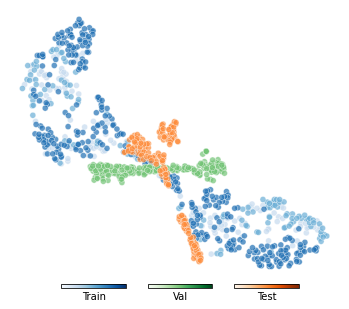

In [9]:
# no mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_30.png")

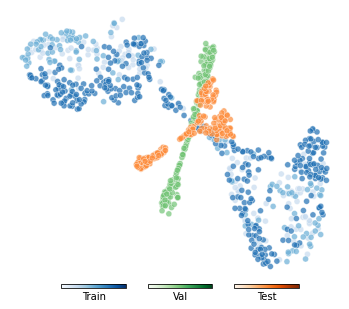

In [12]:
# no mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)
X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_50.png")

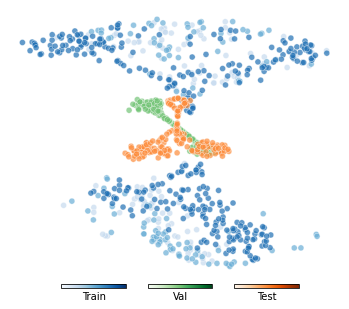

In [13]:
# no mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)
X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_80.png")

# Run Mix Up Experiments Below

In [14]:
# mix up
model = build_model('densenet121', NUM_CLASSES['camelyon17'], NUM_DOMAINS['camelyon17'], 1, 1)
model.load_state_dict(torch.load(cam_mix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [15]:
# mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 10:
        break
val_features = np.array(val_features).reshape(-1, 1024)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 20:
        break
test_features = np.array(test_features).reshape(-1, 1024)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 1024)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(200, 1024) (200,)
val id:  [1]
(200, 1024) (200,)
test id:  [2]
(600, 1024) (600,)
val id:  [0 3 4]
50


In [16]:
# mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)


pca = PCA(n_components=20)
pca.fit(X_train)
print(pca.singular_values_)

pca = PCA(n_components=20)
pca.fit(X_val)
print(pca.singular_values_)

pca = PCA(n_components=20)
pca.fit(X_test)
print(pca.singular_values_)

train: (600, 1024) (600,)
val: (200, 1024) (200,)
test: (200, 1024) (200,)
[119.91041    23.445473   17.736301   12.258094   11.529936    9.626736
   7.644114    7.577437    6.4295964   5.9062595   5.8136806   5.4714503
   5.3495507   4.9940543   4.586563    4.260907    3.8284798   3.7277648
   3.5360482   3.4686356]
[55.6213    12.841178  11.633343   9.3340435  6.9217176  6.198459
  5.209988   4.226683   3.8341258  3.4485552  3.2811007  3.180032
  2.9036114  2.8074954  2.657957   2.5735724  2.5255182  2.4611728
  2.2963006  2.283191 ]
[44.291958  15.498155  11.596528   8.222211   6.3944488  5.512815
  4.8017497  4.225082   3.7447112  3.4713652  3.1567962  2.884049
  2.6703033  2.5612364  2.4466734  2.4349346  2.177541   2.1080184
  2.0528183  2.0079305]


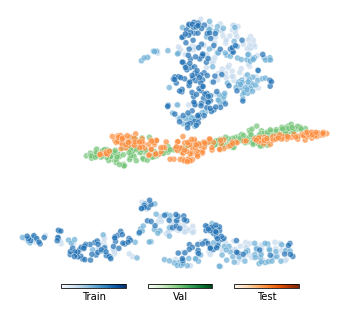

In [17]:
# mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_30.png")

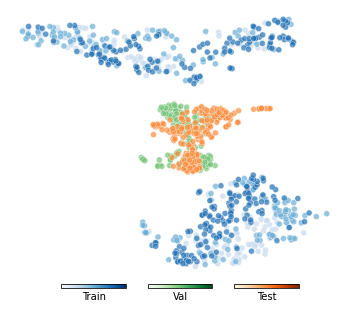

In [18]:
# mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)
X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_50.png")

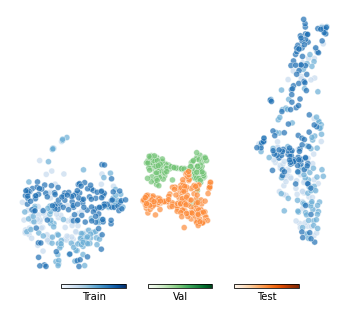

In [19]:
# mix up
X_train_PCA = PCA(n_components=20).fit_transform(X_train)
d_train = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)
X_val_PCA = PCA(n_components=20).fit_transform(X_val)
d_val = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=20).fit_transform(X_test)
d_test = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_80.png")